In [11]:
import pandas as pd
import numpy as np
import sklearn as sk
import pandas_profiling
import sys,os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Can we leverage well-known feature selection strategies, such as Chi-squared ranking, toselect features that are more data-error robust?

Let's collect some statistics about every feature before corrupting the data. 


In [33]:
df=pd.read_csv('./data.csv')
print(df.columns)
corr_matrix = df.corr().copy()
df.head()

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


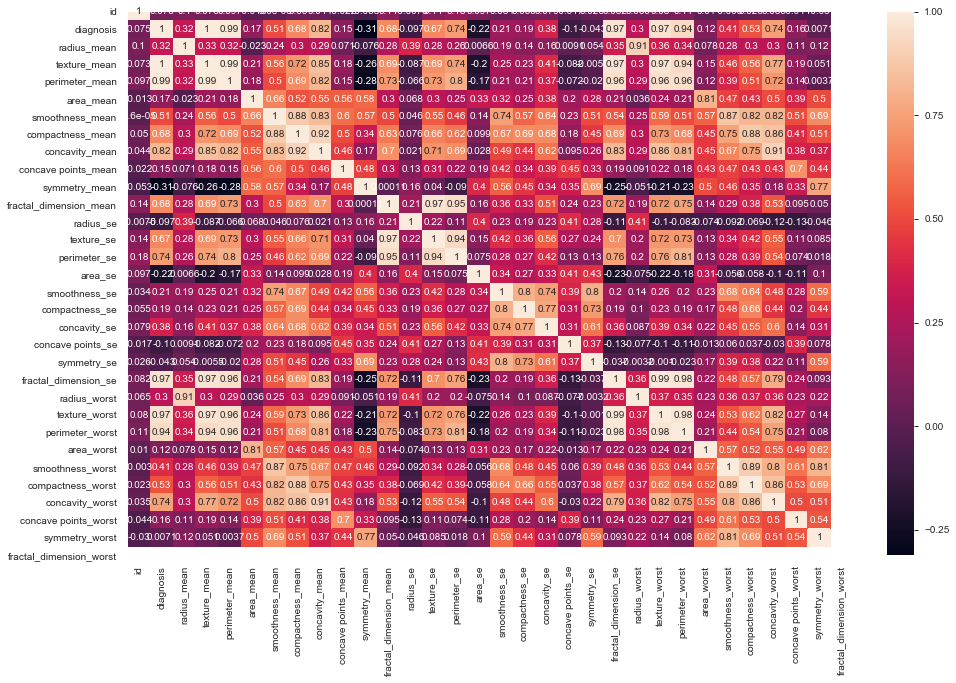

In [34]:
df=pd.read_csv('./data.csv')
df['diagnosis'] =df['diagnosis'].apply(lambda x: 1 if x =="M" else 0)
y = df['diagnosis']

X = df.drop(['diagnosis','id'],axis=1)
feature_cols = X.columns.to_list()
# plot the correlation heatmap
plt.figure(figsize=(16,10))

sns.heatmap(corr_matrix,annot=True,
        xticklabels=df.columns,
        yticklabels=df.columns)



In [67]:
#Correlation with output variable
cor_target = abs(df.corr()["diagnosis"])

mean_correlation = abs(df.corr()).describe().T['mean']
corr_ranking = pd.DataFrame([cor_target,mean_correlation]).T.rename(columns={"diagnosis": "target_correlation", "B": "mean_correlation"})


In [73]:
X_ = StandardScaler().fit_transform(X)
np.set_printoptions(suppress=True)
pca = PCA()
pca = pca.fit(X_)

# summarize components
print("Explained Variance: %s" % pca.explained_variance_ratio_)

Explained Variance: [0.44272026 0.18971182 0.09393163 0.06602135 0.05495768 0.04024522
 0.02250734 0.01588724 0.01389649 0.01168978 0.00979719 0.00870538
 0.00804525 0.00523366 0.00313783 0.00266209 0.00197997 0.00175396
 0.00164925 0.00103865 0.0009991  0.00091465 0.00081136 0.00060183
 0.00051604 0.00027259 0.00023002 0.00005298 0.00002496 0.00000443]


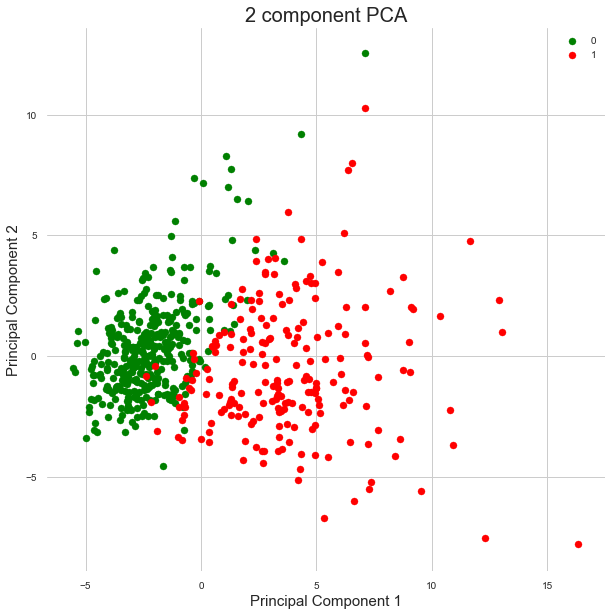

In [75]:
pca = PCA(n_components=2).fit(X_)


finalDf = pd.concat([pd.DataFrame(pca.transform(X_),columns=['principal component 1','principal component 2']), y], axis = 1)


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['diagnosis'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [76]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 3)
fit = rfe.fit(X_, y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
ranking_names =map(lambda x: feature_cols[x],fit.ranking_)
print("Feature Ranking: %s" % list(ranking_names))

Num Features: 3
Selected Features: [False False False False False False False False False False False False
 False False False False False False False False  True False False  True
 False False False  True False False]
Feature Ranking: ['smoothness_se', 'concavity_se', 'concave points_se', 'radius_se', 'compactness_worst', 'perimeter_se', 'compactness_se', 'compactness_mean', 'concave points_worst', 'texture_worst', 'perimeter_mean', 'smoothness_worst', 'texture_se', 'concavity_mean', 'area_worst', 'symmetry_mean', 'concavity_worst', 'fractal_dimension_se', 'perimeter_worst', 'symmetry_se', 'texture_mean', 'area_mean', 'smoothness_mean', 'texture_mean', 'fractal_dimension_mean', 'symmetry_worst', 'concave points_mean', 'texture_mean', 'area_se', 'radius_worst']


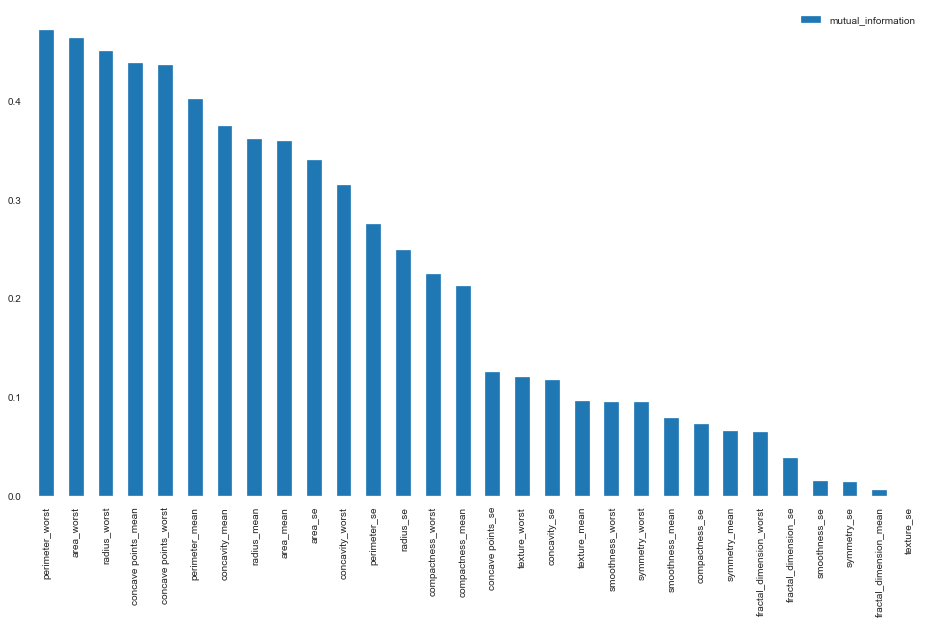

In [92]:
mutual_info = np.array(mutual_info_classif(X_, y, discrete_features='auto', n_neighbors=3, copy=True, random_state=42))

mutual_info= pd.DataFrame(mutual_info,columns=["mutual_information"],index=feature_cols)

mutual_info.sort_values(by='mutual_information',ascending=False)\
        .plot(kind='bar',figsize=(16,9))

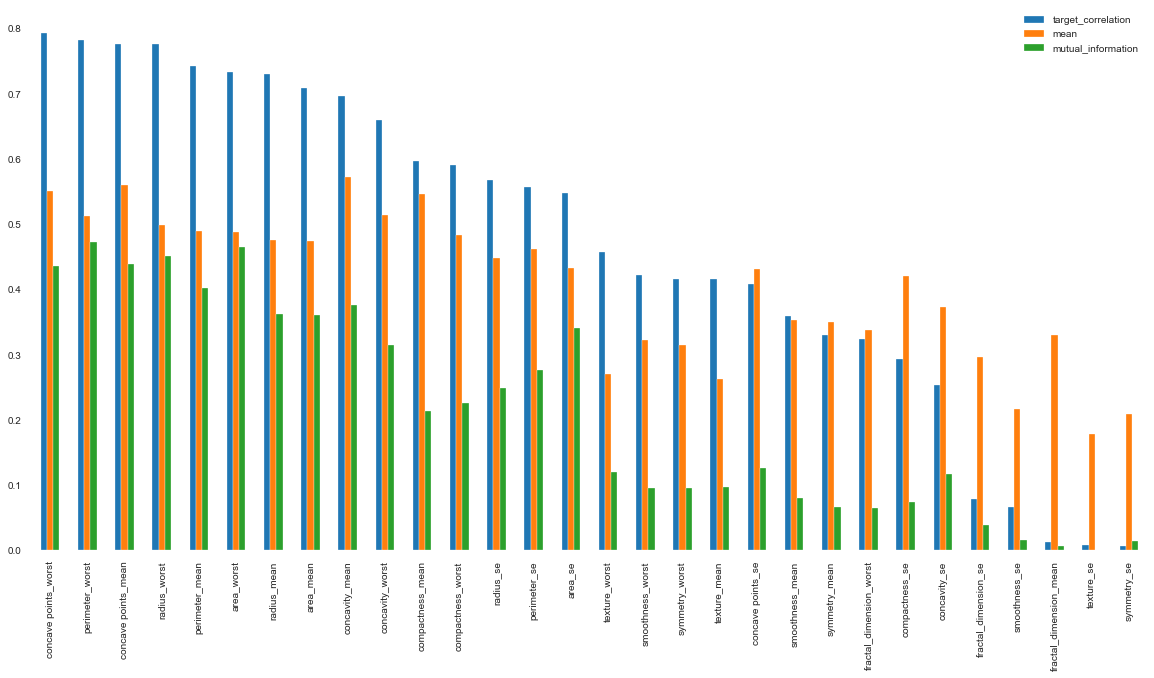

In [104]:
pd.concat([corr_ranking.drop(['id','diagnosis']) , mutual_info],axis=1).sort_values(by=['target_correlation','mean','mutual_information'],ascending=False).plot(kind='bar',figsize=(20,10))